In [1]:
from dask.distributed import Client, LocalCluster
import logging

cluster = LocalCluster(
    n_workers=28,
    threads_per_worker=8,
    silence_logs=logging.DEBUG
)

client = Client(cluster, heartbeat_interval=10000)
print(client.dashboard_link)

distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at:     tcp://127.0.0.1:41015
distributed.scheduler - INFO -   dashboard at:            127.0.0.1:8787
distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:35839'
distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:46579'
distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:39299'
distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:45131'
distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:45085'
distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:36331'
distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:37553'
distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:39833'
distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:44333'
distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:36105'
distributed.nanny - INFO -         Start Nanny at: 'tcp:

http://127.0.0.1:8787/status


In [1]:
import afqinsight as afqi
import joblib
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
import pandas as pd
import pickle
import seaborn as sns

from datetime import datetime

from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import median_absolute_error, r2_score
from sklearn.metrics import explained_variance_score, mean_squared_error

from skopt import BayesSearchCV
from skopt.plots import plot_convergence, plot_objective, plot_evaluations

print(afqi.__version__)

0.2.9.dev460469908


In [2]:
X, y, groups, columns, subjects, classes = afqi.load_afq_data(
    "../data/raw/age_data",
    target_cols=["Age"],
)

In [3]:
label_sets = afqi.multicol2sets(pd.MultiIndex.from_tuples(columns, names=["metric", "tractID", "nodeID"]))

In [4]:
X_md_fa = afqi.select_groups(X, [["fa"], ["md"]], label_sets)

In [5]:
groups_md_fa = groups[:40]

In [6]:
def get_cv_results(n_repeats=5, n_splits=10,
                   power_transformer=False, 
                   shuffle=False,
                   ensembler=None,
                   target_transform_func=None,
                   target_transform_inverse_func=None,
                   n_estimators=10):
    if shuffle:
        rng = np.random.default_rng()
        y_fit = rng.permutation(y)
    else:
        y_fit = np.copy(y)

    cv = RepeatedKFold(
        n_splits=n_splits,
        n_repeats=n_repeats,
        random_state=1729
    )

    cv_results = {}
    pipe_skopt = afqi.make_afq_regressor_pipeline(
        imputer_kwargs={"strategy": "median"},
        use_cv_estimator=True,
        power_transformer=power_transformer,
        scaler="standard",
        groups=groups_md_fa,
        verbose=0,
        pipeline_verbosity=False,
        tuning_strategy="bayes",
        cv=3,
        n_bayes_points=9,
        n_jobs=28,
        l1_ratio=[0.0, 1.0],
        eps=5e-2,
        n_alphas=100,
        ensemble_meta_estimator=ensembler,
        ensemble_meta_estimator_kwargs={
            "n_estimators": n_estimators,
            "n_jobs": 1,
            "oob_score": True,
            "random_state": 1729,
        },
        target_transform_func=target_transform_func,
        target_transform_inverse_func=target_transform_inverse_func,
    )

    for cv_idx, (train_idx, test_idx) in enumerate(cv.split(X_md_fa, y_fit)):
        start = datetime.now()

        X_train, X_test = X_md_fa[train_idx], X_md_fa[test_idx]
        y_train, y_test = y_fit[train_idx], y_fit[test_idx]

        with joblib.parallel_backend("dask"):
            pipe_skopt.fit(X_train, y_train)

        cv_results[cv_idx] = {
            "pipeline": pipe_skopt,
            "train_idx": train_idx,
            "test_idx": test_idx,
            "y_pred": pipe_skopt.predict(X_test),
            "y_true": y_test,
            "test_mae": median_absolute_error(y_test, pipe_skopt.predict(X_test)),
            "train_mae": median_absolute_error(y_train, pipe_skopt.predict(X_train))
        }
        
        if ensembler is None:
            if ((target_transform_func is not None)
                or (target_transform_inverse_func is not None)):
                cv_results[cv_idx]["optimizer"] = pipe_skopt.named_steps["estimate"].regressor_.bayes_optimizer_                
            else:
                cv_results[cv_idx]["optimizer"] = pipe_skopt.named_steps["estimate"].bayes_optimizer_

        print(f"CV index [{cv_idx:3d}], Elapsed time: ", datetime.now() - start)
        
    return cv_results, y_fit

In [7]:
# results = {}
# results["no_power_transform"] = get_cv_results(
#     n_splits=10, n_repeats=5, power_transformer=False, shuffle=False
# )
# results["shuffle_no_transform"] = get_cv_results(
#     n_splits=10, n_repeats=3, power_transformer=False, shuffle=True
# )

with open("age_regression.pkl", "rb") as fp:
    results = pickle.load(fp)

In [8]:
# results["target_log_transform"] = get_cv_results(
#     n_splits=10, n_repeats=5, power_transformer=False, shuffle=False,
#     target_transform_func=np.log, target_transform_inverse_func=np.exp,
# )

# results["shuffle_target_log_transform"] = get_cv_results(
#     n_splits=10, n_repeats=3, power_transformer=False, shuffle=True,
#     target_transform_func=np.log, target_transform_inverse_func=np.exp,
# )

In [9]:
# with open("age_regression.pkl", "wb") as fp:
#     pickle.dump(results, fp)

In [10]:
results.keys()

dict_keys(['no_power_transform', 'shuffle_no_transform', 'target_log_transform', 'shuffle_target_log_transform', 'bagging', 'bagging_shuffle', 'bagging_target_transform', 'bagging_shuffle_target_transform'])

In [11]:
for key, res in results.items():
    test_accuracies = [cvr["test_mae"] for cvr in res[0].values()]
    train_accuracies = [cvr["train_mae"] for cvr in res[0].values()]
    print(key, "test", np.mean(test_accuracies))
    print(key, "train", np.mean(train_accuracies))

no_power_transform test 5.540696905638893
no_power_transform train 3.1133809418435243
shuffle_no_transform test 10.000112734459126
shuffle_no_transform train 8.880698628408233
target_log_transform test 3.9961240900046517
target_log_transform train 2.0457675914648776
shuffle_target_log_transform test 8.068634524528376
shuffle_target_log_transform train 5.435306399303147
bagging test 4.501028671611233
bagging train 2.2366376650158983
bagging_shuffle test 8.010468681241846
bagging_shuffle train 4.136229247395444
bagging_target_transform test 3.928384494534197
bagging_target_transform train 1.756664544387215
bagging_shuffle_target_transform test 7.2155398122255905
bagging_shuffle_target_transform train 3.70189829720499


In [12]:
import itertools

def mean_over_combinations(results):
    length = len(results)
    mean_results = {}
    for r in range(1, length + 1):
        mean_results[r] = [
            np.mean([res["yhat"].values for res in comb], axis=0)
            for comb in itertools.combinations(results, r=r)
        ]
        
    return mean_results

def mae_over_combinations(results):
    mean_results = mean_over_combinations(results)
    mean_mae = []
    for r in mean_results.keys():
        mean_mae += [
            {
                "n_repeats": r,
                "mae": median_absolute_error(results[0]["y_true"].values, res)
            } for res in mean_results[r]
        ]
        
    return pd.DataFrame(mean_mae)

def get_mae_ensemble_dataframe(cv_results, y_true):    
    test_preds = {
        idx: pd.Series(
            data=cvr["y_pred"],
            index=cvr["test_idx"],
            name="yhat"
        )
        for idx, cvr in cv_results.items()
    }
    
    df_ytest = {
        idx: pd.DataFrame(test_preds[idx]).merge(
            pd.DataFrame(y_true, columns=["y_true"]),
            left_index=True,
            right_index=True,
            how="left"
        ) for idx in test_preds.keys()
    }
    
    mae_scores = [
        median_absolute_error(_df["y_true"].values, _df["yhat"].values)
        for _df in df_ytest.values()
    ]
    
    repeats = [
        pd.concat([df_ytest[i] for i in range(x * 10, (x + 1) * 10)]).sort_index()
        for x in range(len(cv_results) // 10)
    ]
    
    return mae_over_combinations(repeats)

In [13]:
df_mae = {
    key: get_mae_ensemble_dataframe(res[0], y)
    for key, res in results.items()
}

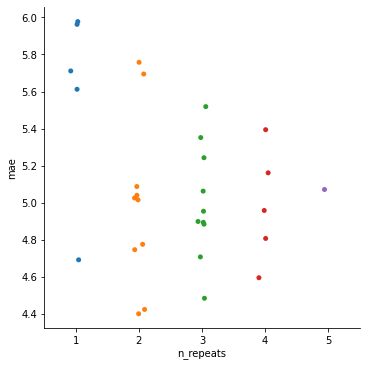

In [14]:
sns.catplot(x="n_repeats", y="mae", data=df_mae["no_power_transform"])

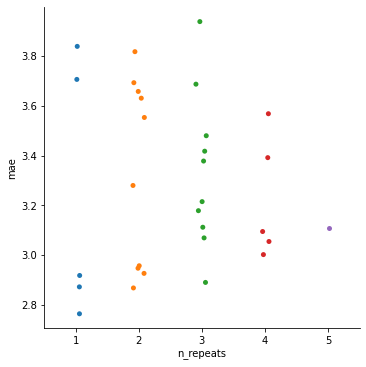

In [15]:
sns.catplot(x="n_repeats", y="mae", data=df_mae["target_log_transform"])

In [16]:
# results["bagging"] = get_cv_results(
#     n_splits=10, n_repeats=1, power_transformer=False,
#     ensembler="serial-bagging", shuffle=False, n_estimators=20,
# )
# results["bagging_shuffle"] = get_cv_results(
#     n_splits=10, n_repeats=1, power_transformer=False,
#     ensembler="serial-bagging", shuffle=True, n_estimators=10,
# )

In [17]:
# results["bagging_target_transform"] = get_cv_results(
#     n_splits=10, n_repeats=1, power_transformer=False,
#     ensembler="serial-bagging", shuffle=False, n_estimators=20,
#     target_transform_func=np.log, target_transform_inverse_func=np.exp,
# )
# results["bagging_shuffle_target_transform"] = get_cv_results(
#     n_splits=10, n_repeats=1, power_transformer=False,
#     ensembler="serial-bagging", shuffle=True, n_estimators=10,
#     target_transform_func=np.log, target_transform_inverse_func=np.exp,
# )

In [23]:
for key, res in results.items():
    test_accuracies = [cvr["test_mae"] for cvr in res[0].values()]
    train_accuracies = [cvr["train_mae"] for cvr in res[0].values()]
    print(key, "mean", np.mean(test_accuracies))
    print(key, "std", np.std(test_accuracies))

no_power_transform mean 5.540696905638893
no_power_transform std 2.13400766841705
shuffle_no_transform mean 10.000112734459126
shuffle_no_transform std 2.480757848589296
target_log_transform mean 3.9961240900046517
target_log_transform std 2.4596337548141944
shuffle_target_log_transform mean 8.068634524528376
shuffle_target_log_transform std 2.853527694157889
bagging mean 4.501028671611233
bagging std 2.112326622952927
bagging_shuffle mean 8.010468681241846
bagging_shuffle std 3.0911806897880827
bagging_target_transform mean 3.928384494534197
bagging_target_transform std 2.263365951473496
bagging_shuffle_target_transform mean 7.2155398122255905
bagging_shuffle_target_transform std 2.9519512135251778


In [19]:
# with open("age_regression.pkl", "wb") as fp:
#     pickle.dump(results, fp)

In [21]:
bagging_results = results["bagging_target_transform"][0]

({0: {'pipeline': Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                   ('scale', StandardScaler()), ('power_transform', None),
                   ('estimate',
                    TransformedTargetRegressor(func=<ufunc 'log'>,
                                               inverse_func=<ufunc 'exp'>,
                                               regressor=SerialBaggingRegressor(base_estimator=SGLCV(cv=3,
                                                                                                     eps=0.05,
                                                                                                     groups=[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
          17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 2...
          2955, 2956, 2957, 2958, 2959, 2960, 2961, 2962, 2963, 2964, 2965,
          2966, 2967, 2968, 2969, 2970, 2971, 2972, 2973, 2974, 2975, 2976,
          2977, 2978, 2979, 2980, 2981, 2982, 2983, 2984, 2985